https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

#1) Äriliste eesmärkide seadmine

Olgu meil energiaettevõte, kes toodab oma klientidele elektrit. Elektrienergia salvestamine on üldiselt raske, mistõttu peaks nii tootmine kui ka tarbimine toimuma samas mahus, ehk olema tasakaalus. Elektrienergia tarbimine ehk nõudlus ei ole kogu aeg sama, vaid võib sõltuda paljudest asjaoludest nagu aastajast, kellaajast, ilmast jne. Et klientide energiatarbimist paremini ennustada, otsustab energiaettevõte luua mudeli, mis leiab varasemate tarbimis- ja tootmismustrite vahel vajalikud seosed, mis aitavad tulevikus tarbimismahtusid paremini prognoosida. <br><br>

Selleks kasutavad nad kahte lähenemist: klassikalist aegridade mudelit nagu ARIMA, ning kaasaegsemat masinõppel põhinevat LSTM tehisnärvivõrku.

#2) Andmete mõistmine

Andmestik koosneb 4 aasta jooksul Hispaanias kogutud ilmastiku ja energia tootmise ning tarbimise kohta. Andmed ilmastiku ja energia tootmise/tarbimise kohta on kogutud kahte erinevasse faili. Laeme need failid arvutisse.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
energy = pd.read_csv("https://drive.google.com/uc?export=download&id=1nuPZ8JKBUMUQi9bc2DTrbcIurULd2sgb")
weather = pd.read_csv("https://drive.google.com/uc?export=download&id=1QB6vfTItiscQ_gyVzC5cb7-8V8XGHxUx")

Weather andmestik on saadud Open Weather API (https://openweathermap.org/api) kaudu ning sisaldab näiteks õhutemperatuuri, õhuniiskust, tuule kiirust, sademeid jne. 

In [11]:
weather

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n


Energy andmestik sisaldab energia tootmist mitmesugustest allikatest nagu biomassist, fossiilõlist, tuulest, päikesest jne. Lisaks sisaldab andmestik iga päeva kohta energia tarbimise mahtu (vt tabeli veergude lõpus tunnus "total load actual") ning energia hinda (vt tabeli viimaste veergude seast "price actual").

In [12]:
energy

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


Nii weather kui ka energy andmestikus on mõõtmised tehtud täpselt samadel kellaaegadel ja kuupäevadel. Ühise aja alusel saame need kaks andmetabelit ühendada, nii et ühes andmetabelis on veerud nii energia tabelist kui ka ilmastiku tabelist. Siis saame mudeli loomiseks kasutada rohkem tunnuseid. Paneme aga tähele, et nendes tabelites on aega kirjeldav veerg tähistatud erineva nimega, kuid kui me tahame kahte tabelit mingi ühise veeru järgi liita, peavad veerunimed klappima. Muudame ilmastiku tabelis veeru "dt_time" ümber samaks, mis energia tabelis - lihtsalt "time".

In [13]:
weather = weather.rename(columns={'dt_iso': 'time'})

Nüüd, kui mõlemas tabelis on ajaveeru nimi "time", saame need kaks tabelit selle veeru järgi kokku liita.

In [14]:
df = pd.merge(energy, weather, how='inner', on = 'time')

In [15]:
df

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,0,226,0.0,0.0,0.0,0,800,clear,sky is clear,01
3,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,7,58,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,1,21,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 23:00:00+01:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,...,2,300,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,2018-12-31 23:00:00+01:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,...,1,360,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,2018-12-31 23:00:00+01:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,...,2,100,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,2018-12-31 23:00:00+01:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,...,5,310,0.0,0.0,0.0,0,800,clear,sky is clear,01n


Andmed, mida mudeli loomiseks kasutame, koosnevad erinevatest mõõtmistulemustest järjestikustel kellaaegadel ja päevadel. Ühe tunnuse (nt füüsikalise suuruse nagu temperatuur) järjestikused väärtused moodustavad <b>aegrea</b>. Aegrea väärtuste muutumist ajas saab visualiseerida graafiliselt. Et aegridasid visuali

In [18]:
df.dtypes

time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil coal-derived gas             float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation fossil oil shale                    float64
generation fossil peat                         float64
generation geothermal                          float64
generation hydro pumped storage aggregated     float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation marine                              float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation

Et meie programm "time" veergu ka tegelikult ajana käsitleks, on vaja see tunnus eelnevalt muuta "DatetimeIndex"-iks.

In [23]:
df["time"] = pd.to_datetime(df["time"], utc=True)
df.index = pd.DatetimeIndex(df.time)

Kuna tunnise täpsusega on mitme aasta andmete peale aegrea kujutamine väga arvutusmahukas, aeglane ja ebavajalik, siis saame meie aegrea täpsust ja sagedust muuta ka näiteks nädalapõhiseks (W) või kuupõhiseks (M).

In [37]:
g1 = df.groupby(pd.Grouper(freq="M")) #Muudame aegrea sageduse kuupõhiseks, s.t temperatuuri ei kuvata iga tunni kohta, vaid võetakse iga kuu keskmine temperatuur.
g1 = g1.mean()

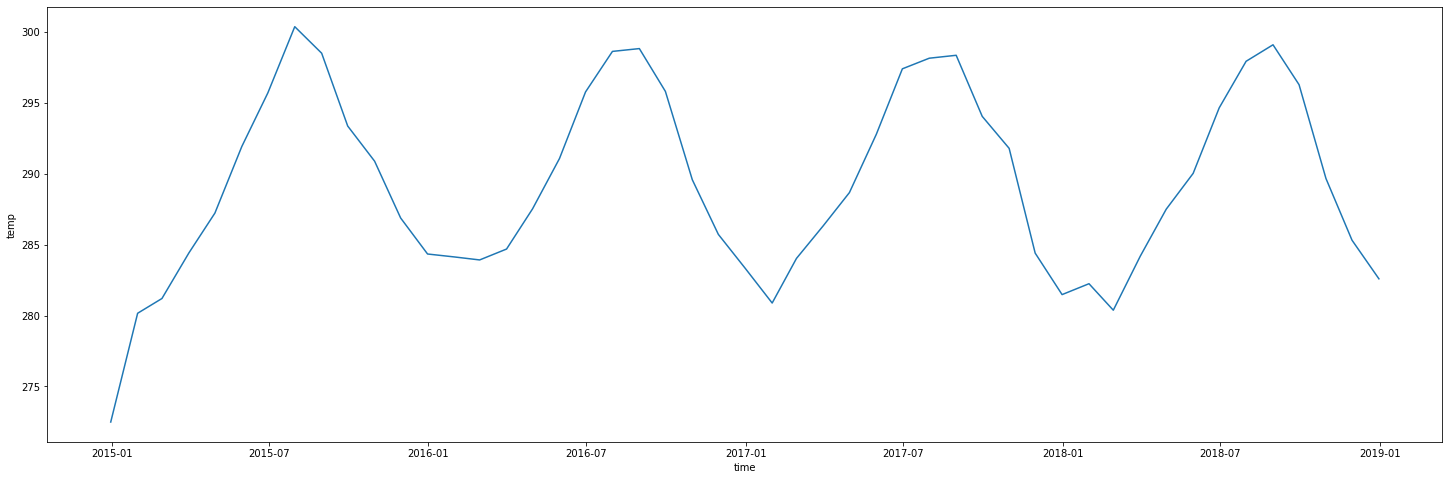

In [38]:
plt.figure(figsize = (25,8)) #Joonise suuruse sättimine
sns.lineplot(x = 'time', y = 'temp', data = g1) #sns.lineplot abil saame joongraafikuid (nt aegridasid) kuvada

Kuvame sama aegrea päevapõhise täpsusega ja näeme, kuidas aegrida on juba oluliselt säbrulisem (suurema ajasageduse tõttu granulaarsem).

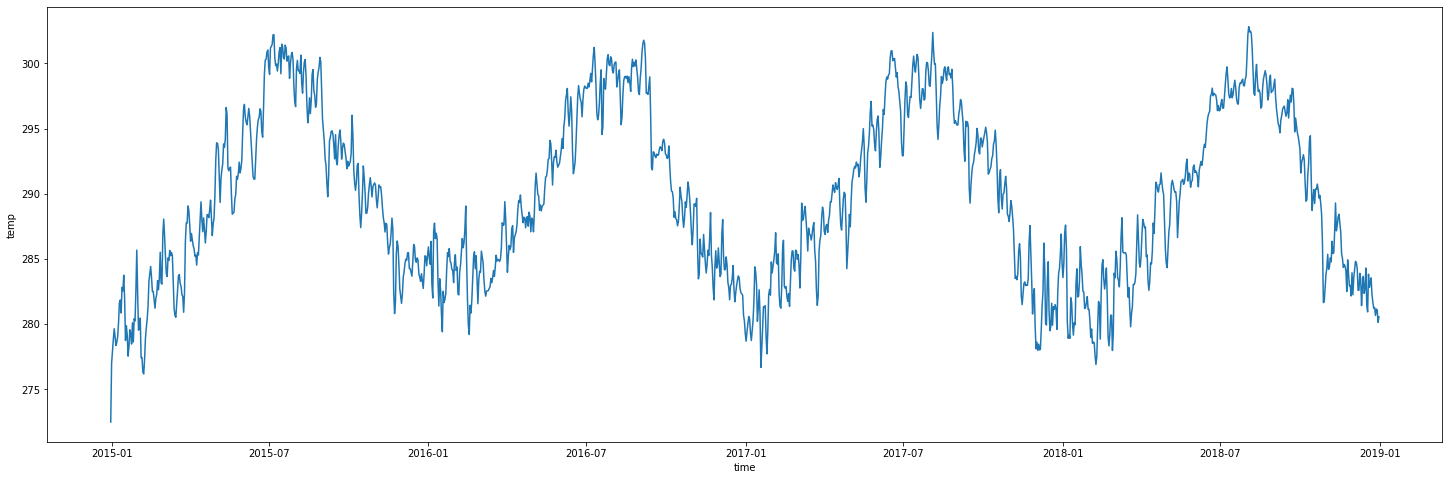

In [33]:
g2 = df.groupby(pd.Grouper(freq="D")) 
g2 = g2.mean()

plt.figure(figsize = (25,8))
sns.lineplot(x = 'time', y = 'temp', data = g2) 

Me saame samal graafikul kuvada ka mitut aegrida korraga ja neid võrrelda. Ettevaatlik tuleb aga olla, et kuna erinevate tunnuste väärtused võivad olla väga erinevas mõõtkavas, siis võivad ühe aegrea väärtused samal joonisel teisi aegridasid suuruse poolest väga domineerida ning väikseks muuta. 

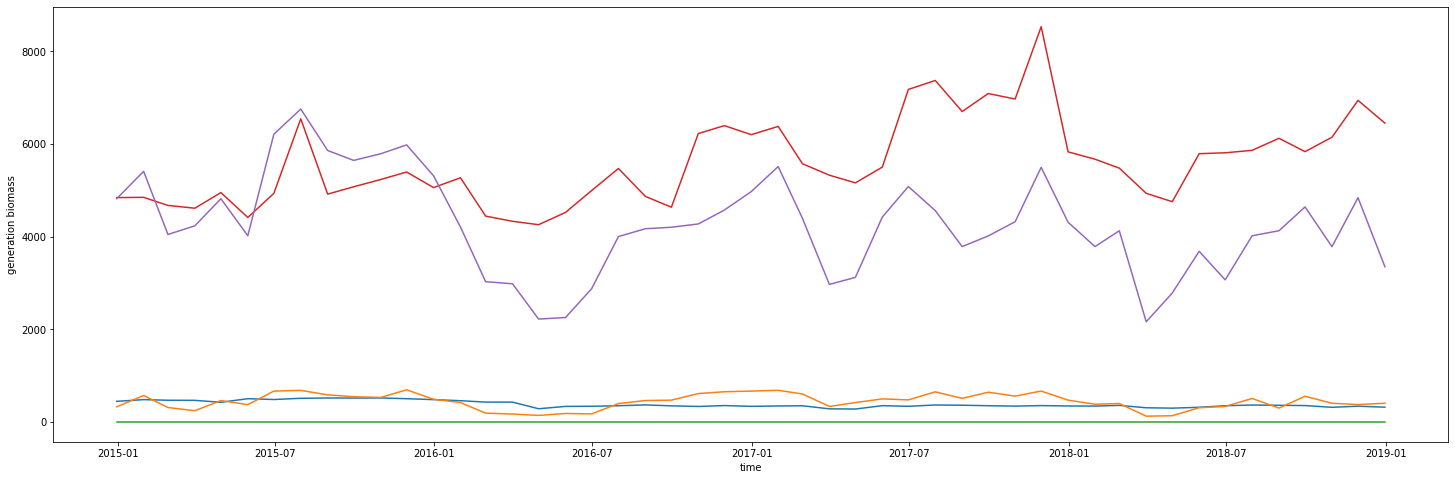

In [39]:
plt.figure(figsize = (25,8))
sns.lineplot(x = 'time', y = 'generation biomass',data = g1)
sns.lineplot(x = 'time', y = 'generation fossil brown coal/lignite',data = g1)
sns.lineplot(x = 'time', y = 'generation fossil coal-derived gas',data = g1)
sns.lineplot(x = 'time', y = 'generation fossil gas',data = g1)
sns.lineplot(x = 'time', y = 'generation fossil hard coal',data = g1)

##Korreleeruvad aegread

Kui me võrdleme ühel joonisel kahte aegrida, siis võime mõnikord näha, kuidas nende aegridade väärtused suurenevad ja vähenevad samal ajal. Mida rohkem nende aegridade üles-alla muutumine ühtib, seda enam nad <b>korreleeruvad</b>. Korrelatsioonide abil saame me andmeridade vahel leida võimalikke seoseid ning seejärel ühe aegrea väärtusi ennustada/prognoosida teise andmerea väärtustest.

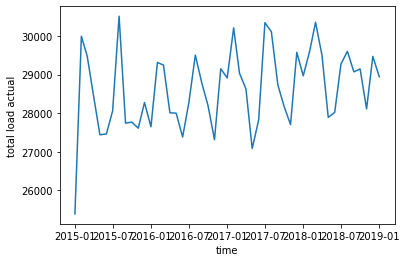

In [53]:
sns.lineplot(x = 'time', y = 'total load actual', data = g1)

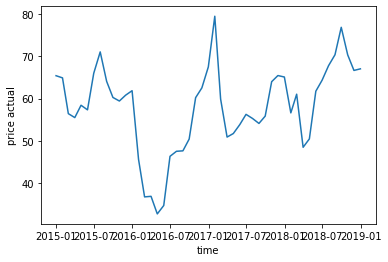

In [45]:
sns.lineplot(x = 'time', y = 'price actual', data = g1)

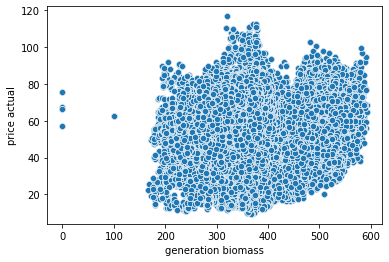

In [41]:
sns.scatterplot(data=df, x="generation biomass", y="price actual")

Kui kahe aegrea vaheline korrelatsioon on väike, siis ei pruugi veel tähendada, et need aegread korreleeritud pole. Võib olla, et üks aegrida hakkan teise aegreaga samal viisil muutuma, aga mitte kohe, vaid vähese hilinevusega. Selleks <b>nihutatakse</b> ühte ajarida teise suhtes ning arvutatakse nendevaheline korrelatsioon uuesti. Harilikult ei tehta nihutust vaid ühe korra, vaid mitmeid kordi, ning iga nihutuse puhul arvutatakse uus korrelatsioon. Sellisel juhul saame me korrelatsioone kujutada graafiliselt, kus X-teljel on nihutuse suurus, ning Y-teljel sellele nihutusele vastava aegridade vaheline korrelatsioon. Harilikult tähistatakse vastava korrelatsiooni suurust püstkriipsuga, mille otsas on punkt.

In [ ]:
import statsmodels.tsa.stattools as smt

ccf_output = smt.ccf(g1['temp'],g1['generation biomass'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0, 0.5, 'ACF')

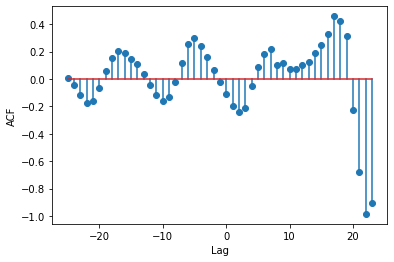

In [69]:
import matplotlib.pylab as plt
import numpy as np
#np.random.seed(123)
#test = pd.DataFrame(np.random.randint(0,25,size=(79, 2)), columns=list('AB'))
#backwards = smt.ccf(test['B'], test['A'], unbiased=False)[::-1]
#forwards = smt.ccf(test['A'], test['B'], unbiased=False)
#ccf_output = np.r_[backwards[:-1], forwards]
plt.stem(range(-len(ccf_output)//2, len(ccf_output)//2), ccf_output)
plt.xlabel('Lag')
plt.ylabel('ACF')
# 95% UCL / LCL
#plt.axhline(-1.96/np.sqrt(len(test)), color='k', ls='--') 
#plt.axhline(1.96/np.sqrt(len(test)), color='k', ls='--')

##Aegrea lahutamine trendiks, sesoonseks komponendiks ja juhuslikuks komponents
Statistiliste meetodite abil on esialgne aegrida võimalik lahutada erinevateks komponentideks, mis aegrida moodustavad. </br>
<b>Trend</b> iseloomustab aegrea väärtuste üldist/laiahaardelist kulgu, s.t kui aegrea väärtused küll käivad vähesel määral üles-alla, siis suures plaanis aegrea väärtused kas suurenevad või vähenevad. </br>
<b>Sesoonne komponent</b> väljendab aegrea perioodilisi muutusi, s.t kuigi aegrida tervikuna või suures plaanis või kahaneda või kasvada, siis võib aegreas tihti näha perioodilisi kasvamisi ja kahanemisi (nt aastaajast või kellaajast sõltuvalt). </br>
<b>Juhuslik komponent</b> on see osa aegreast, mis trendist ja sesoonsest komponendist alles jääb ning mille mõjutajaks on juhus või mõni muu seletamatu nähtus.  

<Figure size 640x960 with 0 Axes>

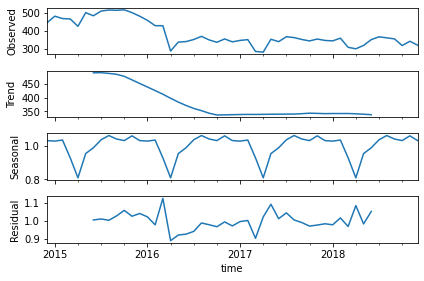

In [52]:
from matplotlib import pyplot
from matplotlib.pyplot import figure
figure(figsize=(8, 12), dpi=80)

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(g1[["generation biomass"]], model='multiplicative')

result.plot()
pyplot.show()

###Autocorrelations

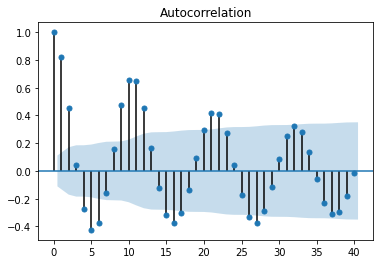

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
dta = sm.datasets.sunspots.load_pandas().data
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]
sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40)
plt.show()

#3) Andmete ettevalmistamine

In [70]:
import numpy as np
mape = np.mean(np.abs((df['total load actual'] - df['total load forecast']) / df['total load actual'])) * 100
print('MAPE of the forecasted data present in DataFrame:', mape)

MAPE of the forecasted data present in DataFrame: 1.095515089612755


array([[34651.],
       [34651.],
       [34651.],
       ...,
       [24455.],
       [24455.],
       [24455.]])

In [107]:
from sklearn.preprocessing import MinMaxScaler

temp = df.copy() # make temporary copy of dataframe
dataset = temp['total load actual'].dropna().values # numpy.ndarray of the actual load
dataset = dataset.astype('float32') 
dataset = np.reshape(dataset, (-1, 1)) # reshape to one feature; required for the models

scaler = MinMaxScaler(feature_range=(0, 1)) # Min Max scaler
dataset = scaler.fit_transform(dataset) # fit and transform the dataset

# Train and Test splits
train_size = int(len(dataset) * 0.80) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25 # timesteps to lookback for predictions
X_train, trainY = create_dataset(train, look_back)
X_test, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("Shapes: \nTraining set: {}, Testing set: {}".format(X_train.shape, X_test.shape))
print("Sample from training set: \n{}".format(X_train[0]))

Shapes: 
Training set: (142546, 1, 25), Testing set: (35618, 1, 25)
Sample from training set: 
[[0.31966567 0.31966567 0.31966567 0.31966567 0.31966567 0.27600765
  0.27600765 0.27600765 0.27600765 0.27600765 0.20427442 0.20427442
  0.20427442 0.20427442 0.20427442 0.14124662 0.14124662 0.14124662
  0.14124662 0.14124662 0.09676152 0.09676152 0.09676152 0.09676152
  0.09676152]]


In [73]:
X_train.shape

(142546, 1, 25)

In [75]:
X_test.shape

(35618, 1, 25)

#4) Mudeldamine

##Klassikaline statistilise analüüsi mudel - AutoRegressive (AR)

In [113]:
from statsmodels.tsa.ar_model import AR

model = AR(train)
model_fit = model.fit()

In [114]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)

print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

Test Mean Absolute Error: 3861.6793340770164
Test Root Mean Squared Error: 4523.149284813523


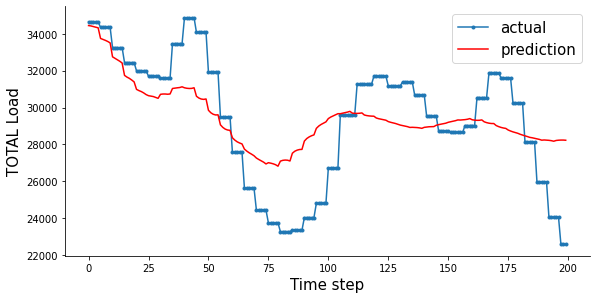

In [115]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## LSTM tehisnärvivõrgul põhinev mudel

In [127]:
#temp = temp.drop(["price actual", "price day ahead", "total load actual", "total load forecast"], axis=1)

In [128]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#temp = df
dataset = temp['total load actual'].dropna().values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)


X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

KeyError: ignored

In [139]:
X_train.shape

(142546, 1, 25)

In [119]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=10, batch_size=70, validation_data=(X_test, Y_test),verbose=1, shuffle=False)

model.summary()

Epoch 1/10
2037/2037 [==============================] - 27s 9ms/step - loss: 0.0028 - val_loss: 9.6439e-04
Epoch 2/10
2037/2037 [==============================] - 14s 7ms/step - loss: 0.0012 - val_loss: 5.6897e-04
Epoch 3/10
2037/2037 [==============================] - 16s 8ms/step - loss: 0.0010 - val_loss: 4.9235e-04
Epoch 4/10
2037/2037 [==============================] - 25s 12ms/step - loss: 8.5605e-04 - val_loss: 6.3335e-04
Epoch 5/10
2037/2037 [==============================] - 27s 13ms/step - loss: 8.3607e-04 - val_loss: 4.9659e-04
Epoch 6/10
2037/2037 [==============================] - 15s 7ms/step - loss: 7.2867e-04 - val_loss: 4.6737e-04
Epoch 7/10
2037/2037 [==============================] - 13s 6ms/step - loss: 7.1380e-04 - val_loss: 4.4637e-04
Epoch 8/10
2037/2037 [==============================] - 11s 5ms/step - loss: 6.9273e-04 - val_loss: 4.6777e-04
Epoch 9/10
2037/2037 [==============================] - 11s 5ms/step - loss: 7.0897e-04 - val_loss: 4.2560e-04
Epoch 10/10

In [120]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
mape_train = np.mean(np.abs((Y_train[0] - train_predict[:,0]) / Y_train[0])) * 100
mape_test = np.mean(np.abs((Y_test[0] - test_predict[:,0]) / Y_test[0])) * 100

print("Train MAPE: {}, Test MAPE: {}".format(mape_train, mape_test))

Train Mean Absolute Error: 262.05950305789673
Train Root Mean Squared Error: 486.45956533689855
Test Mean Absolute Error: 259.14257972495585
Test Root Mean Squared Error: 476.59517907716753
Train MAPE: 0.9162709782934042, Test MAPE: 0.8994077611857751


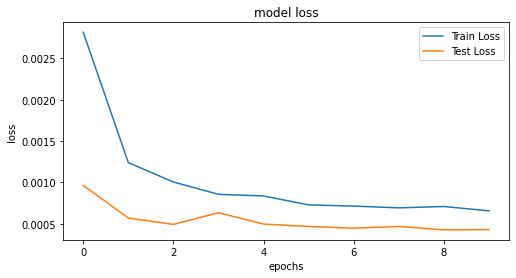

In [121]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

Kuvame samal graafikul aegrea tegelikud väärtused (sinise joonega) ning mudeli poolt ennustatud väärtused (punase joonega) 200 ajasammu jaoks.

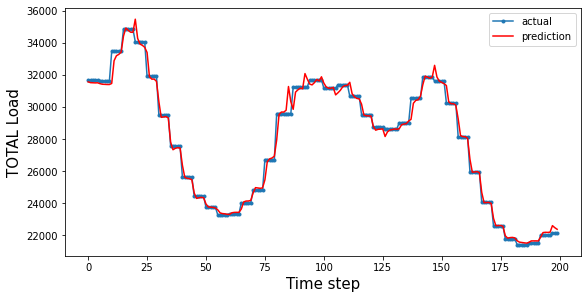

In [137]:
plt.figure(figsize=(8,4))

timesteps = range(200)
plt.plot(timesteps, Y_test[0][:idx], marker='.', label="actual")
plt.plot(timesteps, test_predict[:,0][:idx], 'r', label="prediction")

plt.tight_layout()
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend()
plt.show();

Võrdle saadud tulemust statistilise analüüsi (AR) meetodiga.

# 5) Projekti tulemuste hindamine

# 6) Kasutusele võtmine ehk juurutamine

https://www.kaggle.com/datasets/theforcecoder/wind-power-forecasting